In [51]:
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.exposure import match_histograms
# homedir = '/global/home/users/cowherd/cssltimeseries/'
homedir = '/Users/cowherd/documents/info290t/'
os.chdir(homedir)

In [52]:
al = plt.imread('a3-al.png')

In [53]:
def myconvolve(I, kernel):
    n,m = I.shape[0],I.shape[1]
    I_blur = np.zeros((n,m))
    for j in range(0,n):
        for k in range(0,m):
            tmp = I[max(0,j-1):min(j,j+2), max(0,k-1):min(k,k+2)]
            out = 0
            for a in range(tmp.shape[0]):
                for b in range(tmp.shape[1]):
                    ida = a
                    idb = b
                    if j>n-2: ida = a+(n-j)
                    if k>m-2: idb = b+(m-k)
                    out+= tmp[a,b]*kernel[ida][idb] 
            I_blur[j,k] = out
    return I_blur

def unsharp(I,k, kernel):
    I_blur = myconvolve(I, kernel)
    I_unsharp = I + k * (I-I_blur)
    return I_unsharp

In [56]:
from scipy import ndimage
blurkernel = [[0.0625, 0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]]
k = np.arange(0,20,0.5)
al_unsharp1 = unsharp(al,1,blurkernel)
al_unsharp1 = match_histograms(al_unsharp1,al)
al_unsharp20 = unsharp(al,20,blurkernel)
al_unsharp20 = match_histograms(al_unsharp20, al)  # image, reference, channel
img_y = ndimage.convolve(al, blurkernel, mode='reflect') 

Part 1: Sharpening: An image can be sharpened by enhancing its high frequencies (e.g., Photoshop's unsharp mask). Implement an unsharp mask that takes as input a grayscale image (I), blurs this image (I_blur), and adds a variable amount (k) of the image's high frequency (I-I_blur) back into the image: I_sharp = I + k(I-I_blur).

Your solution should generate a gif animation of images sharpened with k = np.arange(0,20,0.5). Because adding back an image's high frequency will change the contrast, use skimage.exposure's match_histograms to match the sharpened image's intensity distribution to the original image's intensity distribution. Test your code on al.png.

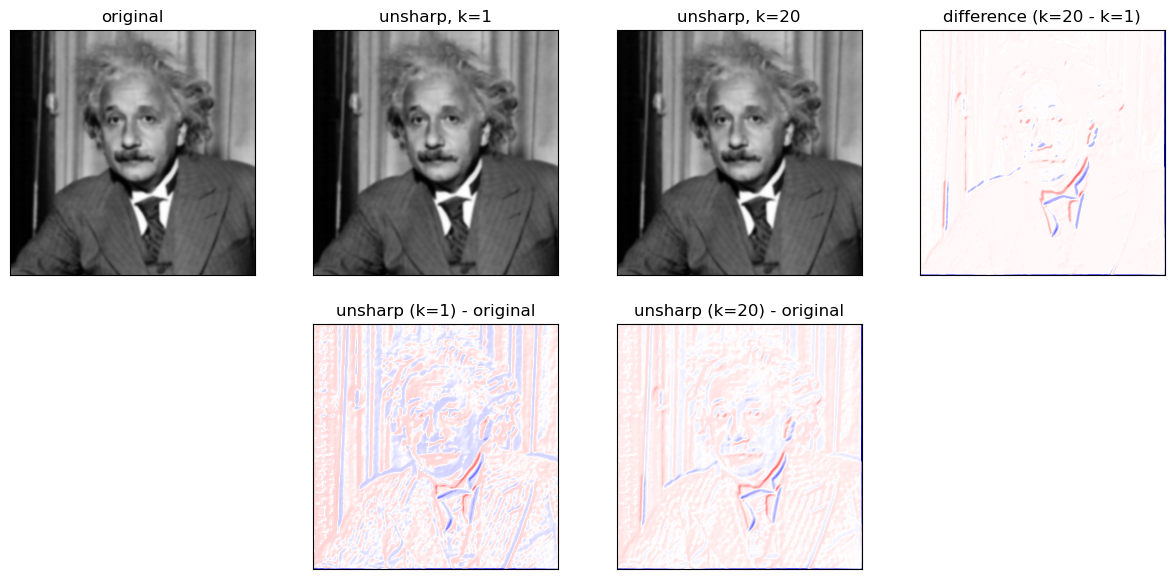

In [57]:
plt.figure(figsize=(15,7))
#
plt.subplot(2,4,1)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al,cmap='gray')
plt.title('original')
#
plt.subplot(2,4,2)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al_unsharp1,cmap='gray')
plt.title('unsharp, k=1')
#
plt.subplot(2,4,6)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al_unsharp1-al,cmap='seismic')
plt.title('unsharp (k=1) - original')
#
plt.subplot(2,4,3)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al_unsharp20, cmap='gray')
plt.title('unsharp, k=20')
#
plt.subplot(2,4,7)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al_unsharp20-al,cmap='seismic')
plt.title('unsharp (k=20) - original')
#
#
plt.subplot(2,4,4)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al_unsharp20 - al_unsharp1,cmap='seismic')
plt.title(r'difference (k=20 - k=1)')
plt.show()

In [58]:
# initialize the animation file
import imageio.v2 as imageio
gif_writer = imageio.get_writer('blur-test-diff.gif', mode='I')
for kval in k:
    al_unsharp = unsharp(al,kval,blurkernel)
    al_unsharp = match_histograms(al_unsharp,al)
    plot_img = al - al_unsharp
    gif_writer.append_data(plot_img)    
gif_writer.close()

# initialize the animation file
import imageio.v2 as imageio
gif_writer = imageio.get_writer('blur.gif', mode='I')
for kval in k:
    al_unsharp = unsharp(al,kval,blurkernel)
    al_unsharp = match_histograms(al_unsharp,al)
    plot_img = al_unsharp
    gif_writer.append_data(plot_img)    
gif_writer.close()

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.012044817209243552, 0.016051791008049876]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.0206738993959521, 0.024530962002363044]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.026774846274277175, 0.03137951263525973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.029642443446551203, 0.034214465275115624]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03131487702622193, 0.03559740230762687]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.03350634171682221, 0.03852447224177902]. Conve

Part 2: Deconvolution: Given a grayscale image (Ih) convolved with a filter (h), implement a deconvolution function that returns the original image (I), where Ih = I * h.

Since we are only considering 1D convolution, we can consider the convolution (and deconvolution) of each image row separately. To begin, formulate a 1D convolution as f_h = A f_o, where f_o is a n x 1 vector corresponding to a row of the input (original) image, f_h is n x 1 vector corresponding to a row of the output (convolved) image, and A is a n x n convolution matrix in which each row is a shifted version of the convolution kernel. For example, for the 1D filter h = [1,2,1] and n = 7, then the 7 x 7 convolution matrix A is (notice that we are handing image edges by wrapping the kernel):

[[2. 1. 0. 0. 0. 0. 1.]
 [1. 2. 1. 0. 0. 0. 0.]
 [0. 1. 2. 1. 0. 0. 0.]
 [0. 0. 1. 2. 1. 0. 0.]
 [0. 0. 0. 1. 2. 1. 0.]
 [0. 0. 0. 0. 1. 2. 1.]
 [1. 0. 0. 0. 0. 1. 2.]]
    
Once convolution is formulated as f_h = A f_o, deconvolution is simply f_o = inv(A) f_h (note that A is a square matrix).

Write a Python function deconvolution that takes as input a grayscale image (Ih) and filter (h) and returns the original image (I) by deconvoling each image row one at a time using the above formulation.

To test your code, convolve the image al.png with the filter [-1,0.001,1] -- use our 1D implementation of convolution that handles edges as described above. Display all three images: the original image, the filtered image, and the deconvolved image (the original and deconvolved images should, of course, be nearly identical.


In [ ]:
from scipy import linalg

def make_mat(img,h):
    n,m = img.shape
    ## create the large matrix:
    H = np.zeros((m,m)) # based on the length of each row. doesnt matter here bc al is square, but matters in general
    h0 = h[0]
    h1 = h[1]
    h2 = h[2]
    # do the first row manually
    H[0,0] = h1
    H[0,1] = h2
    H[0,-1] = h0
    # iterate
    for j in range(1,n-1):
        H[j,j-1] = h0
        H[j,j] = h1
        H[j,j+1] = h2
    # do the last row manually
    H[m-1,m-2] = h0
    H[m-1,m-1] = h1
    H[m-1,0] = h2
    return np.matrix(H)
        
def convolve(img, h):
    H = make_mat(img,h)
    n,m = img.shape
    con_img = np.zeros((n,m))
    for j in range(n):
        f = img[j,:]
        f_h = H@f
        con_img[j,:] = f_h
    return con_img

def deconvolve(img, h):
    H = make_mat(img,h)
    n,m = img.shape
    Hinv = linalg.inv(H)
    decon_img = np.zeros((n,m))
    for j in range(n):
        f_h = img[j,:]
        f = Hinv@f_h
        decon_img[j,:] = f
    return decon_img

In [ ]:
h = [-1,0.001,1]
al_con = convolve(img=al, h = h)
al_decon = deconvolve(img = al_con, h=h)

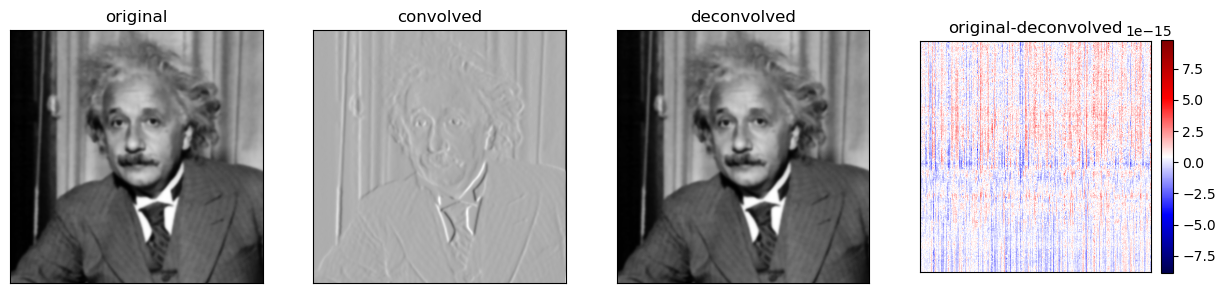

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al,cmap='gray')
plt.title('original')
plt.subplot(1,4,2)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al_con, cmap='gray')
plt.title('convolved')
plt.subplot(1,4,3)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al_decon,cmap='gray')
plt.title('deconvolved')
plt.subplot(1,4,4)
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.imshow(al-al_decon,cmap='seismic')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('original-deconvolved')
plt.show()